In [1]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import cv2
import random

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torchvision.datasets import FashionMNIST

# __________end of block__________ё

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 26421880/26421880 [00:18<00:00, 1423317.74it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 577344.95it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4422102/4422102 [00:01<00:00, 3525581.51it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 7199825.61it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Text(0.5, 1.0, 'Image label: 2')

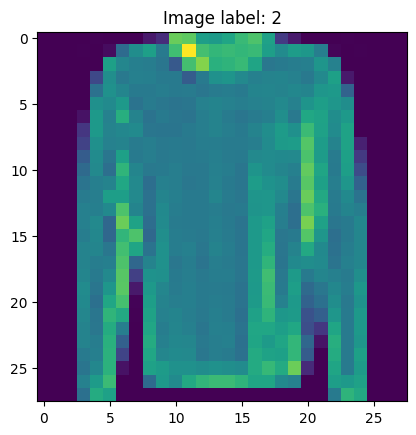

In [2]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)

train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

# Шаг 1: Sobel filtering

## Вычисляем градиенты изображения по осям X и Y с помощью оператора Собеля

In [3]:
# do not change the code in the block below
# __________start of block__________
import numpy as np
def compute_sobel_gradients_two_loops(image):
    # Get image dimensions
    height, width = image.shape

    # Initialize output gradients
    gradient_x = np.zeros_like(image, dtype=np.float64)
    gradient_y = np.zeros_like(image, dtype=np.float64)

    # Pad the image with zeros to handle borders
    padded_image = np.pad(image, ((1, 1), (1, 1)), mode='constant', constant_values=0)
# __________end of block__________

    # Define the Sobel kernels for X and Y gradients
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # Apply Sobel filter for X and Y gradients using convolution
    for i in range(1, height + 1):
      for j in range(1, width + 1):
          segment = padded_image[i-1 : i+2, j-1 : j+2].copy()
          gradient_x[i-1, j-1] = np.sum(segment * sobel_x)
          gradient_y[i-1, j-1] = np.sum(segment * sobel_y)

    return gradient_x, gradient_y

In [4]:
# do not change the code in the block below
# __________start of block__________
def compute_sobel_gradients_opencv(image):
    # Apply Sobel filter for horizontal and vertical gradients
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    
    # Return gradients in both directions
    return sobel_x, sobel_y
# __________end of block__________

In [5]:
# do not change the code in the block below
# __________start of block__________
image = train_fmnist_data[7][0][0].numpy()
gradients_two_loops = compute_sobel_gradients_two_loops(image)
gradients_opencv = compute_sobel_gradients_opencv(image)

assert np.allclose(gradients_two_loops[0][1:-1, 1:-1], gradients_opencv[0][1:-1, 1:-1], atol=1e-2), "gradients_two_loops[0] and gradients_opencv[0] are not close"
assert np.allclose(gradients_two_loops[1][1:-1, 1:-1], gradients_opencv[1][1:-1, 1:-1], atol=1e-2), "gradients_two_loops[1] and gradients_opencv[1] are not close"
print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


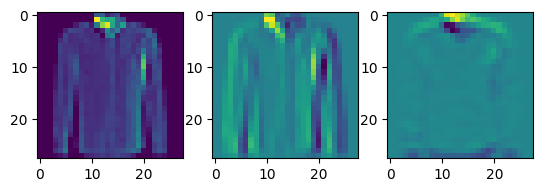

In [6]:
image = random.choice(train_fmnist_data)[0][0].numpy()
gradients_two_loops = compute_sobel_gradients_two_loops(image)

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.imshow(gradients_two_loops[0])
plt.subplot(1, 3, 3)
plt.imshow(gradients_two_loops[1])

# Шаг 2: Подсчет градиентов в полярных координатах

In [7]:
def compute_gradient_magnitude(sobel_x, sobel_y):
    return np.sqrt(sobel_x**2 + sobel_y**2)


def compute_gradient_direction(sobel_x, sobel_y):
    return np.arctan2(sobel_y, sobel_x)

In [8]:
# do not change the code in the block below
# __________start of block__________
image = train_fmnist_data[7][0][0].numpy()
gradients_two_loops = compute_sobel_gradients_two_loops(image)

magnitudes = compute_gradient_magnitude(gradients_two_loops[0], gradients_two_loops[1])
angles = compute_gradient_direction(gradients_two_loops[0], gradients_two_loops[1])
assert np.all(magnitudes >= 0), "Magnitudes should be non-negative"
assert np.all(angles > -180) and np.all(angles <= 180), "Angles should be in the range (-180, 180]"
print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


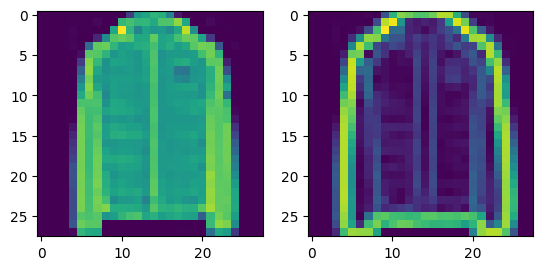

In [9]:
image = random.choice(train_fmnist_data)[0][0].numpy()
magnitudes = compute_gradient_magnitude(*compute_sobel_gradients_two_loops(image))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(magnitudes)

## Шаг 3: Упрощённый вариант HoG

In [10]:
cell_size = 7

def compute_hog(image, pixels_per_cell=(cell_size, cell_size), bins=9):
    # 1. Convert the image to grayscale if it's not already
    if len(image.shape) == 3:
        image = np.mean(image, axis=2)  # Simple averaging to convert to grayscale
    
    # 2. Compute gradients with Sobel filter
    gradient_x, gradient_y = compute_sobel_gradients_two_loops(image)

    # 3. Compute gradient magnitude and direction
    magnitude = compute_gradient_magnitude(gradient_x, gradient_y)
    direction = compute_gradient_direction(gradient_x, gradient_y)

    # Преобразование углов из [-π, π] в диапазон [-180, 180]
    direction = np.rad2deg(direction)  # Переводим радианы в градусы
    direction[direction < -180] += 360  # Приводим к диапазону [-180, 180]
    direction[direction > 180] -= 360  # Приводим к диапазону [-180, 180]

    # 4. Create histograms of gradient directions for each cell
    cell_height, cell_width = pixels_per_cell
    n_cells_x = image.shape[1] // cell_width
    n_cells_y = image.shape[0] // cell_height

    histograms = np.zeros((n_cells_y, n_cells_x, bins))

    bin_width = 360 / bins  # Ширина одного бина (для диапазона [-180, 180])

    for i in range(n_cells_y):
        for j in range(n_cells_x):
            y_start, y_end = i * cell_height, (i + 1) * cell_height
            x_start, x_end = j * cell_width, (j + 1) * cell_width
            
            cell_magnitude = magnitude[y_start:y_end, x_start:x_end]
            cell_direction = direction[y_start:y_end, x_start:x_end]

            for mg, dir in zip(cell_magnitude.ravel(), cell_direction.ravel()):
                dr = int((dir + 180) // bin_width)
                dr = dr - 1 if dr == bins else dr
                histograms[i, j, dr] += mg

            histogram_sum = np.sum(histograms[i, j, :])
            if histogram_sum > 0:
                histograms[i, j, :] /= histogram_sum

    return histograms

In [12]:
# do not change the code in the block below
# __________start of block__________
image = random.choice(train_fmnist_data)[0][0].numpy()

hog = compute_hog(image)
assert hog.shape == (4, 4, 9), "hog should have shape (4, 4, 9) for the FashionMNIST image with default parameters"
print("Everything seems fine!")

assert os.path.exists("hog_data.npy") and os.path.exists("image_data.npy"), "hog_data.npy and image_data.npy should be in the same directory as the notebook"
with open("hog_data.npy", "rb") as f:
    hog_data = np.load(f, allow_pickle=True)
with open("image_data.npy", "rb") as f:
    image_data = np.load(f, allow_pickle=True)
for test_image, test_hog in zip(image_data, hog_data):
    hog = compute_hog(test_image)
    assert np.allclose(hog, test_hog), "hog should be the same"

# __________end of block__________

Everything seems fine!


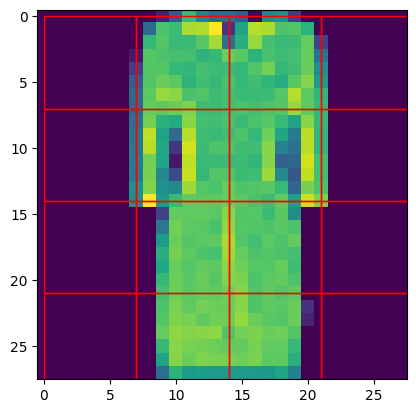

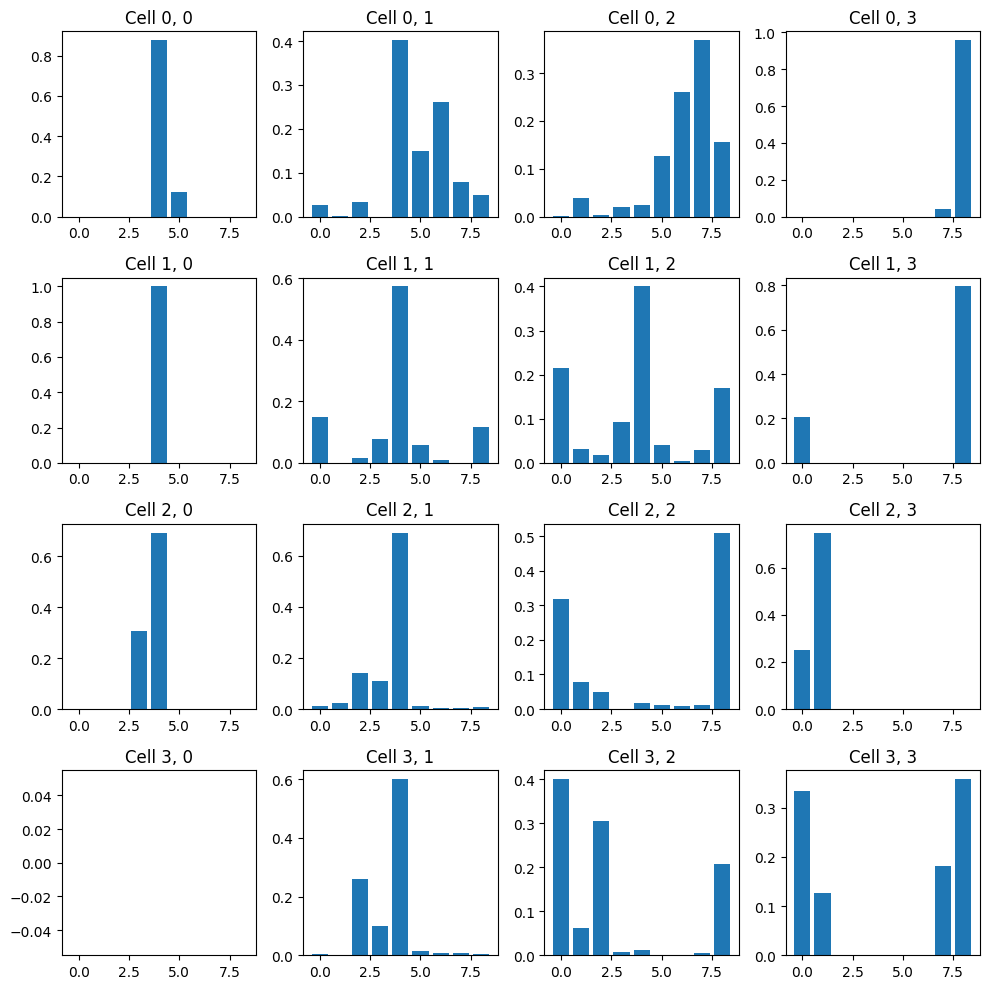

In [15]:
#plot all the histograms for (3, 3) cells:
image = random.choice(train_fmnist_data)[0][0].numpy()
hog = compute_hog(image)

# draw cells on the image
plt.imshow(image)
for i in range(4):
    for j in range(4):
        plt.gca().add_patch(plt.Rectangle((j * cell_size, i * cell_size), cell_size, cell_size, fill=False, edgecolor='red', linewidth=1))
plt.show()


plt.figure(figsize=(10, 10))

for i in range(4):
    for j in range(4):
        plt.subplot(4, 4, i * 4 + j + 1)
        plt.bar(range(len(hog[i, j])), hog[i, j])
        plt.title(f"Cell {i}, {j}")
plt.tight_layout()
plt.show()